<a href="https://colab.research.google.com/github/nrimsky/mlexperiments/blob/main/modular_addtion/modular_addition_network_dynamics_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [383]:
!pip install einops

In [384]:
import torch as t
import einops
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from torch.autograd import grad

# Constants

In [488]:
P = 53
TRAIN_FRAC = 0.7
HIDDEN_SIZE = 128
LR = 0.01
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
BATCH_SIZE = 256
EMBED_DIM = 8

# Model architecture

In [489]:
class MLP(t.nn.Module):
    def __init__(self, embed_dim, vocab_size, hidden_dim, tie_unembed=False):
        super().__init__()
        self.embedding = t.nn.Embedding(vocab_size, embed_dim)
        self.linear1 = t.nn.Linear(embed_dim, hidden_dim, bias=True)
        self.tie_unembed = tie_unembed
        if tie_unembed:
          self.linear2 = t.nn.Linear(hidden_dim, embed_dim, bias=True)
        else:
          self.linear2 = t.nn.Linear(hidden_dim, vocab_size, bias=True)
        self.gelu = t.nn.GELU()
        self.vocab_size = vocab_size

    def forward(self, x1, x2):
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)
        x1 = self.linear1(x1)
        x2 = self.linear1(x2)
        x = x1 + x2
        x = self.gelu(x)
        x = self.linear2(x)
        if self.tie_unembed:
          x = x @ self.embedding.weight.T
        return x

# Make dataset

In [490]:
def get_all_pairs(p):
  pairs = []
  for i in range(p):
    for j in range(p):
      pairs.append((i,j))
  return set(pairs)

In [491]:
def make_dataset(p):
  data = []
  pairs = get_all_pairs(p)
  for a, b in pairs:
    data.append(((t.tensor(a), t.tensor(b)), t.tensor((a + b) % p)))
  return data


In [492]:
make_dataset(3)

[((tensor(0), tensor(1)), tensor(1)),
 ((tensor(1), tensor(2)), tensor(0)),
 ((tensor(2), tensor(1)), tensor(0)),
 ((tensor(0), tensor(0)), tensor(0)),
 ((tensor(1), tensor(1)), tensor(2)),
 ((tensor(2), tensor(0)), tensor(2)),
 ((tensor(0), tensor(2)), tensor(2)),
 ((tensor(2), tensor(2)), tensor(1)),
 ((tensor(1), tensor(0)), tensor(1))]

In [493]:
def train_test_split(dataset, train_split_proportion):
  l = len(dataset)
  train_len = int(train_split_proportion * l)
  idx = list(range(l))
  random.shuffle(idx)
  train_idx = idx[:train_len]
  test_idx = idx[train_len:]
  return [dataset[i] for i in train_idx], [dataset[i] for i in test_idx]

In [494]:
dataset = make_dataset(P)

In [495]:
train_data, test_data = train_test_split(dataset, TRAIN_FRAC)

In [496]:
len(train_data), len(test_data)

(1966, 843)

# Training

In [497]:
def test(model, dataset, device):
  n_correct = 0
  model.eval()
  with t.no_grad():
    for (x1, x2), y in dataset:
      out = model(x1.to(device), x2.to(device)).cpu()
      pred = t.argmax(out)
      if pred == y:
        n_correct += 1
  return n_correct / len(dataset)

In [498]:
def train(model, train_dataset, test_dataset, batch_size, lr, n_batches, device):
  model = model.to(device)
  optimizer = t.optim.Adam(model.parameters(), weight_decay=0.0002, lr=lr)
  loss_fn = t.nn.CrossEntropyLoss()
  idx = list(range(len(train_dataset)))
  avg_loss = 0
  print_every = n_batches // 20
  for i in tqdm(range(n_batches)):
    model.train()
    # Sample random batch of data
    batch_idx = random.sample(idx, batch_size)
    X_1 = t.stack([train_dataset[b][0][0] for b in batch_idx]).to(device)
    X_2 = t.stack([train_dataset[b][0][1] for b in batch_idx]).to(device)
    Y = t.stack([train_dataset[b][1] for b in batch_idx]).to(device)
    # Gradient update
    optimizer.zero_grad()
    out = model(X_1, X_2)
    loss = loss_fn(out, Y)
    avg_loss += loss.item()
    loss.backward()
    optimizer.step()
    if i % print_every == 0:
      val_acc = test(model, test_dataset, device)
      avg_loss /= print_every
      print(f"Batch: {i} | Loss: {avg_loss} | Val Acc: {val_acc}")
      avg_loss = 0
  val_acc = test(model, test_dataset, device)
  print(f"Final Val Acc: {val_acc}")
  return model

In [499]:
model = MLP(embed_dim=EMBED_DIM, vocab_size=P, hidden_dim=HIDDEN_SIZE)
model = train(
    model=model,
    train_dataset=train_data,
    test_dataset=test_data,
    batch_size=BATCH_SIZE,
    lr=LR,
    n_batches = 10000,
    device = device
  )

  0%|          | 35/10000 [00:00<01:18, 126.52it/s]

Batch: 0 | Loss: 0.008055740356445313 | Val Acc: 0.013048635824436536


  5%|▌         | 539/10000 [00:02<00:58, 161.36it/s]

Batch: 500 | Loss: 1.4797692371159792 | Val Acc: 0.7532621589561092


 11%|█         | 1069/10000 [00:04<00:36, 247.53it/s]

Batch: 1000 | Loss: 0.045806098010391 | Val Acc: 0.797153024911032


 16%|█▌        | 1565/10000 [00:05<00:33, 250.78it/s]

Batch: 1500 | Loss: 0.031048614997416735 | Val Acc: 0.8469750889679716


 20%|██        | 2049/10000 [00:07<00:33, 236.47it/s]

Batch: 2000 | Loss: 0.027219557918608188 | Val Acc: 0.9015421115065243


 26%|██▌       | 2575/10000 [00:09<00:30, 242.85it/s]

Batch: 2500 | Loss: 0.024456867679953576 | Val Acc: 0.9454329774614472


 31%|███       | 3058/10000 [00:10<00:28, 242.63it/s]

Batch: 3000 | Loss: 0.020328993238508702 | Val Acc: 0.9774614472123369


 35%|███▌      | 3533/10000 [00:12<00:32, 199.65it/s]

Batch: 3500 | Loss: 0.019124690683558584 | Val Acc: 0.9810201660735468


 40%|████      | 4032/10000 [00:14<00:37, 159.51it/s]

Batch: 4000 | Loss: 0.018047481773421168 | Val Acc: 0.9869513641755635


 45%|████▌     | 4539/10000 [00:16<00:22, 241.89it/s]

Batch: 4500 | Loss: 0.01776041728258133 | Val Acc: 0.9893238434163701


 51%|█████     | 5070/10000 [00:17<00:20, 242.32it/s]

Batch: 5000 | Loss: 0.017365957599133255 | Val Acc: 0.9893238434163701


 55%|█████▌    | 5543/10000 [00:19<00:19, 234.04it/s]

Batch: 5500 | Loss: 0.01767521769180894 | Val Acc: 0.9905100830367735


 61%|██████    | 6057/10000 [00:21<00:16, 242.65it/s]

Batch: 6000 | Loss: 0.017379424802958964 | Val Acc: 0.9893238434163701


 65%|██████▌   | 6542/10000 [00:22<00:14, 241.59it/s]

Batch: 6500 | Loss: 0.01722243212349713 | Val Acc: 0.9881376037959668


 71%|███████   | 7063/10000 [00:24<00:11, 250.61it/s]

Batch: 7000 | Loss: 0.01761604677326977 | Val Acc: 0.9928825622775801


 75%|███████▌  | 7549/10000 [00:26<00:15, 161.04it/s]

Batch: 7500 | Loss: 0.016034643951803446 | Val Acc: 0.9916963226571768


 81%|████████  | 8073/10000 [00:28<00:07, 241.26it/s]

Batch: 8000 | Loss: 0.01622103448957205 | Val Acc: 0.9928825622775801


 86%|████████▌ | 8551/10000 [00:29<00:05, 241.64it/s]

Batch: 8500 | Loss: 0.01628539808280766 | Val Acc: 0.9916963226571768


 91%|█████████ | 9065/10000 [00:31<00:03, 239.59it/s]

Batch: 9000 | Loss: 0.016145709831267594 | Val Acc: 0.9916963226571768


 96%|█████████▌| 9567/10000 [00:33<00:01, 231.12it/s]

Batch: 9500 | Loss: 0.016271917508915067 | Val Acc: 0.9928825622775801


100%|██████████| 10000/10000 [00:34<00:00, 290.79it/s]


Final Val Acc: 0.9928825622775801


# Fourier transform

In [500]:
# cos = t.zeros((P, P))
# sin = t.zeros((P, P))
# for i in range(P):
#   for j in range(P):
#     theta = t.tensor(2 * t.pi * i * j / P)
#     cos[i, j] = t.cos(theta)
#     sin[i, j] = t.sin(theta)

# def get_weights_modes(weights):
#   c1 = cos @ (weights @ weights.T)
#   s1 = sin @ (weights @ weights.T)
#   return c1, s1

# def ablate_other_modes(weights, modes):
#     c1 = cos @ weights
#     s1 = sin @ weights
#     mask = t.zeros_like(c1)
#     mask[modes] = 1
#     mask[0] = 1
#     mask[-1 * t.tensor(modes) + P] = 1
#     c1 *= mask
#     s1 *= mask
#     c1 = cos @ c1 / P
#     s1 = sin @ s1 / P
#     return c1 + s1

In [556]:
cos = t.zeros((P, P))
sin = t.zeros((P, P))
for i in range(P):
    for j in range(P):
        theta = t.tensor(2 * t.pi * i * j / P)
        cos[i, j] = t.cos(theta)
        sin[i, j] = t.sin(theta)

def get_weights_modes(weights):
    c1 = cos @ (weights @ weights.T)
    s1 = sin @ (weights @ weights.T)
    return c1, s1

def ablate_other_modes(weights, modes):
    c1 = cos @ weights  # (vocab_size x vocab_size) x (vocab_size x embed_dim) = (vocab_size x embed_dim)
    s1 = sin @ weights  # (vocab_size x vocab_size) x (vocab_size x embed_dim) = (vocab_size x embed_dim)
    all_vecs = t.cat((c1[:P//2+1], s1[P//2+1:]), dim=0) # (vocab_size x embed_dim)
    modes = [0] + modes + [P - mode for mode in modes]  # (k,)
    a = all_vecs[modes] # (k x embed_dim)
    a_at = a @ a.T # (k x k)
    a_at_inv = t.linalg.inv(a_at) # (k x k)
    w = a.T @ a_at_inv @ a # (embed_dim x embed_dim)
    return weights @ w # (vocab_size x embed_dim)

In [553]:
def show_weights_modes(weights, title="Modes"):
  c1, s1 = get_weights_modes(weights)
  n_plots = (P // 2) + 1
  num_cols = int(math.ceil(math.sqrt(n_plots)))
  num_rows = int(math.ceil(n_plots / num_cols))
  colormap = plt.cm.rainbow
  plt.figure(figsize=(num_cols * 2, num_rows * 2))
  colors = [colormap(i) for i in np.linspace(0, 1, P)]
  norms = []
  for mode in range(n_plots):
    cos = c1[mode]
    sin = s1[mode]
    plt.subplot(num_rows, num_cols, mode + 1)
    color_idx = [(i * mode) % P for i in range(P)]
    color_for_mode = [colors[idx] for idx in color_idx]
    avg_norm = sum([np.sqrt(cos[i]**2 + sin[i]**2) for i in range(len(cos))])
    norms.append(avg_norm)
    plt.scatter(cos.numpy(), sin.numpy(), c=color_for_mode)
    plt.title(f"Mode {mode} {avg_norm:.4f}", fontsize=8)
  plt.suptitle(title)
  norm = Normalize(vmin=0, vmax=P)
  sm = ScalarMappable(cmap=colormap, norm=norm)
  cbar_ax = plt.gcf().add_axes([0.92, 0.15, 0.01, 0.7])
  plt.colorbar(sm, cax=cbar_ax)
  plt.tight_layout(rect=[0, 0, 0.9, 1])
  plt.show()

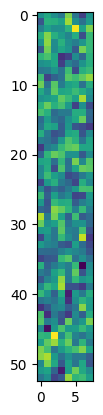

In [538]:
plt.imshow(model.embedding.weight.detach().cpu())

<ipython-input-537-1826daf31b27>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


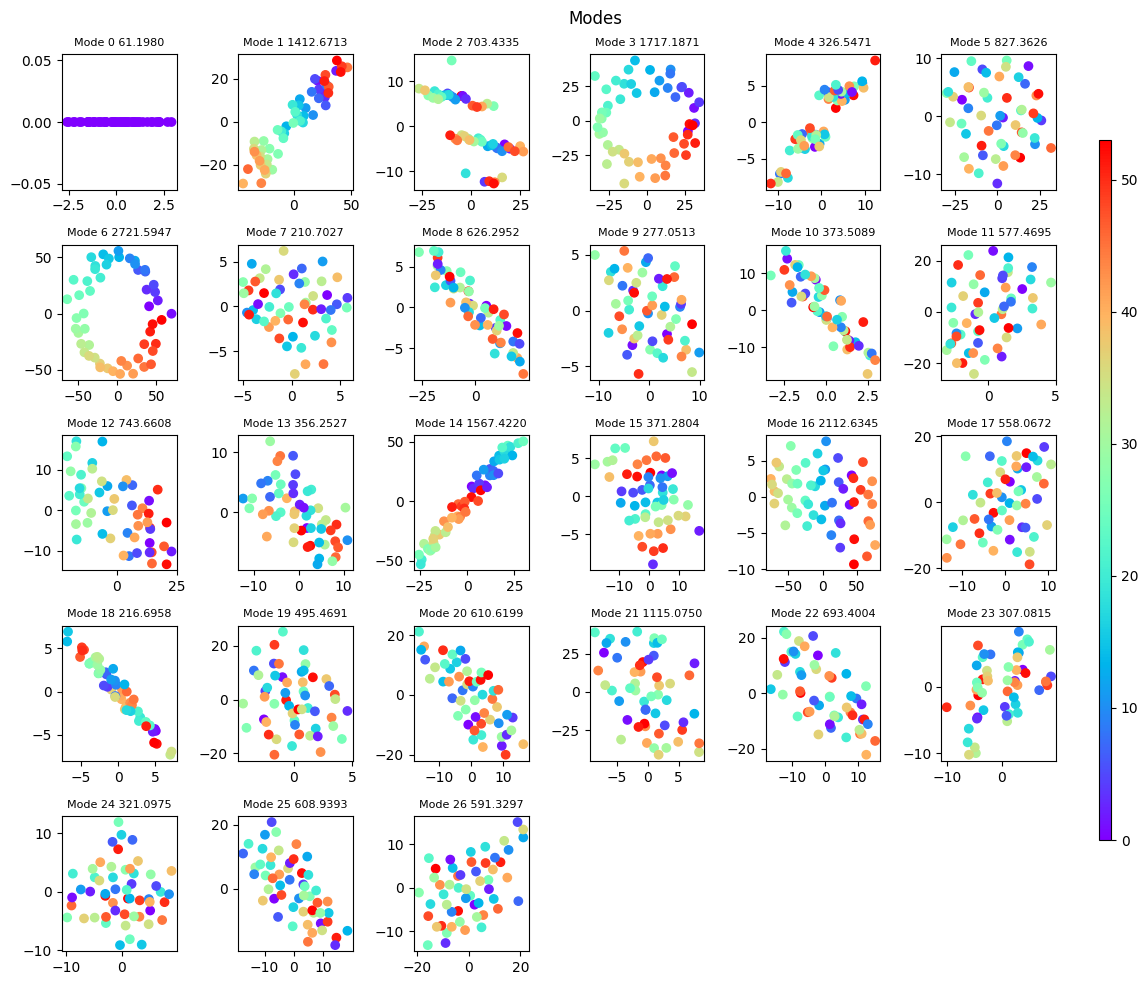

In [539]:
show_weights_modes(model.embedding.weight.detach().cpu())

In [540]:
c, s = get_weights_modes(model.embedding.weight.detach().cpu())

In [541]:
mags = t.sqrt((c**2 + s**2).mean(dim=-1))

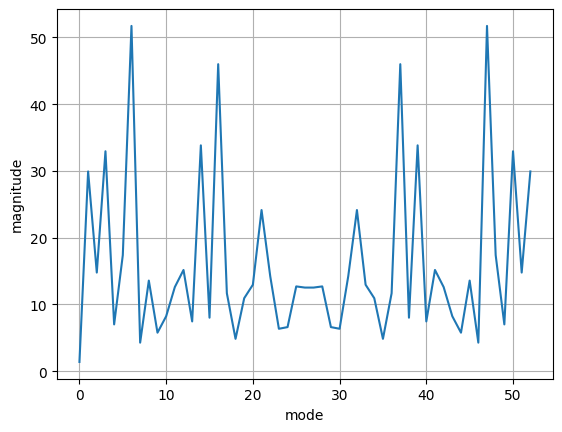

In [542]:
plt.plot(mags)
plt.xlabel("mode")
plt.ylabel("magnitude")
plt.grid()
plt.show()

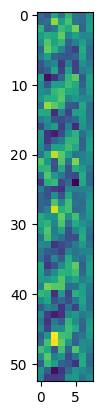

In [544]:
plt.imshow(ablate_other_modes(model.embedding.weight.detach().cpu(), [6]))

<ipython-input-537-1826daf31b27>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


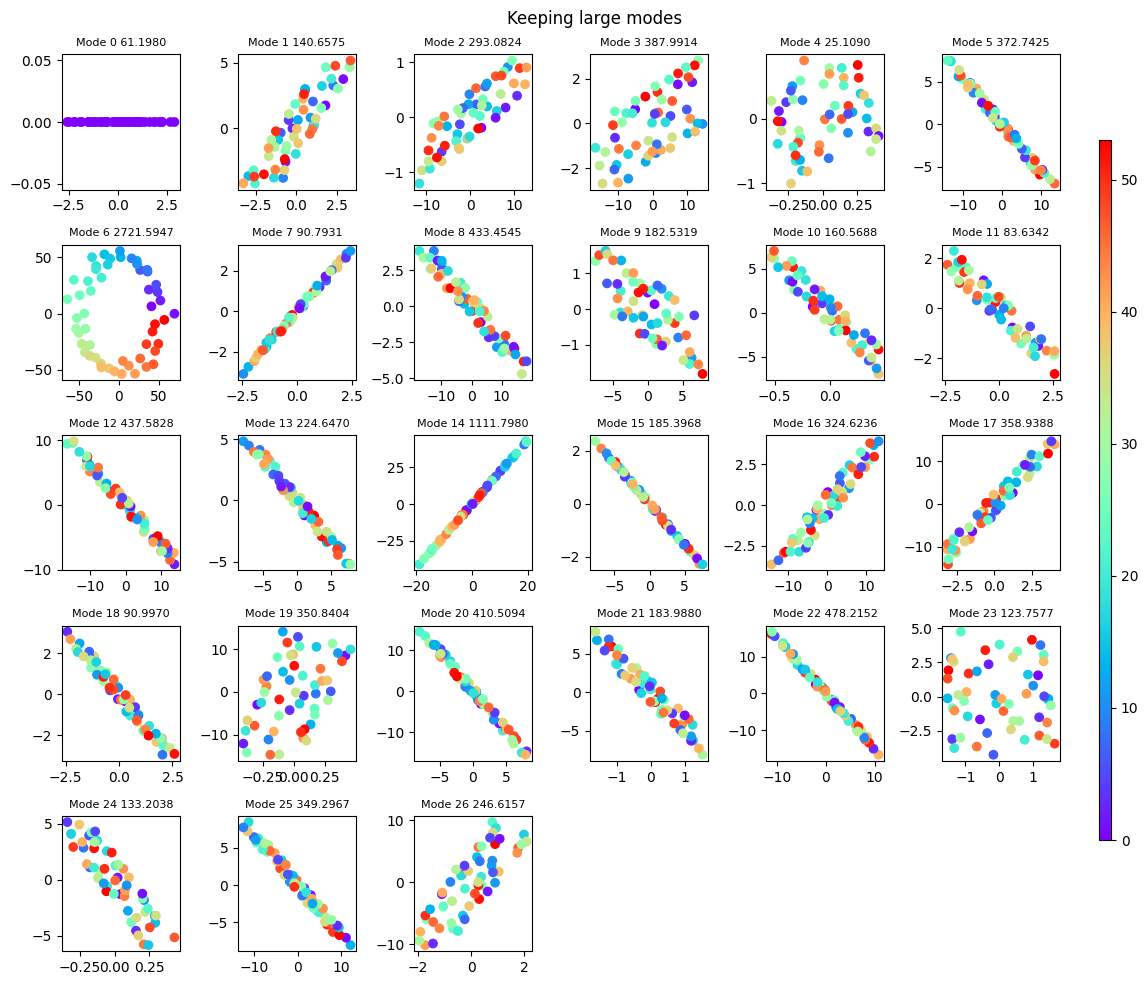

In [545]:
ablated = ablate_other_modes(model.embedding.weight.detach().cpu(), [6])
show_weights_modes(ablated, title="Keeping large modes")

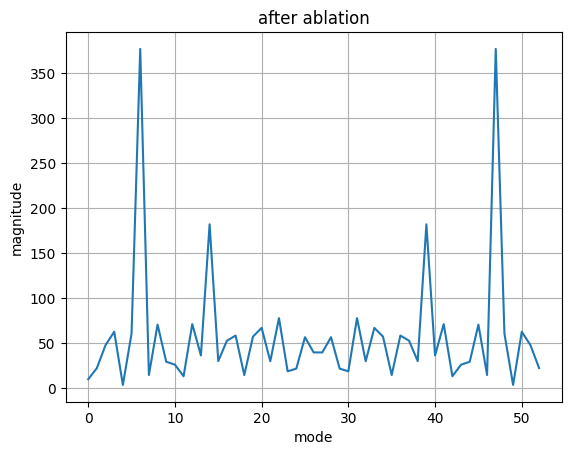

In [546]:
c, s = get_weights_modes(ablated)
mags = t.sqrt((c**2 + s**2).sum(dim=-1))
plt.plot(mags)
plt.xlabel("mode")
plt.ylabel("magnitude")
plt.title("after ablation")
plt.grid()
plt.show()

In [547]:
def eval_model(model, dataset, device):
  model.eval()
  avg_loss = 0
  loss_fn = t.nn.CrossEntropyLoss()
  with t.no_grad():
    for (x1, x2), y in dataset:
      out = model(x1.to(device), x2.to(device)).cpu()
      avg_loss += loss_fn(out, y)
  return avg_loss / len(dataset)

In [548]:
def get_loss_only_modes(model, modes, test_dataset, device, embed_dim=EMBED_DIM, vocab_size=P, hidden_dim=HIDDEN_SIZE, tie_unembed=False):
  model_copy = MLP(embed_dim=embed_dim, vocab_size=vocab_size, hidden_dim=hidden_dim, tie_unembed=tie_unembed)
  model_copy.to(device)
  model_copy.load_state_dict(model.state_dict())
  model_copy.eval()
  model_copy.embedding.weight.data = ablate_other_modes(model_copy.embedding.weight.detach().cpu(), modes).to(device)
  return eval_model(model_copy, test_dataset, device).item()

In [549]:
eval_model(model, test_data, device)

tensor(0.1050)

In [564]:
# get_loss_only_modes(model, list(range(1, P//2)), test_data, device)

In [565]:
get_loss_only_modes(model, [6, 3, 1], test_data, device)

0.23563744127750397

In [566]:
def get_magnitude_modes(weights):
    c1, s1 = cos @ weights, sin @ weights
    return t.sqrt(t.sum(c1**2 + s1**2, dim=-1))

In [567]:
x = get_magnitude_modes(model.embedding.weight.detach().cpu())
x.shape

torch.Size([53])

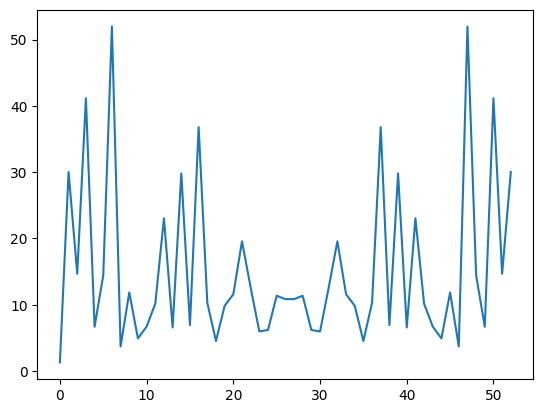

In [568]:
plt.figure()
plt.plot(x)
plt.show()

# Train keeping track of individual mode suspace's loss

In [569]:
hidden_dim = 128 # Use larger hidden dim when freezing layer

In [570]:
def train_with_modes(model, train_dataset, test_dataset, batch_size, lr, n_batches, device, freeze=True, tie_unembed=False):
  model = model.to(device)
  if freeze:
    optimizer = t.optim.Adam(list(model.embedding.parameters()) + list(model.linear2.parameters()), weight_decay=0, lr=lr)
  else:
    optimizer = t.optim.Adam(model.parameters(), weight_decay=0, lr=lr)
  loss_fn = t.nn.CrossEntropyLoss()
  idx = list(range(len(train_dataset)))
  avg_loss = 0
  track_every = n_batches // 20
  print_every = n_batches // 10
  mode_loss_history = []
  magnitude_history = []
  for i in tqdm(range(n_batches)):
    model.eval()
    with t.no_grad():
      if i % track_every == 0:
        mode_losses = {}
        mags = get_magnitude_modes(model.embedding.weight.detach().cpu())
        magnitude_history.append(mags)
        for mode in range(1, P//2 + 1):
          l_mode = get_loss_only_modes(model, [mode], test_dataset, device, hidden_dim=hidden_dim, tie_unembed=tie_unembed)
          mode_losses[mode] = l_mode
        mode_loss_history.append(mode_losses)
      if i % print_every == 0:
          val_acc = test(model, test_dataset, device)
          avg_loss /= print_every
          print(f"Batch: {i} | Loss: {avg_loss} | Val Acc: {val_acc}")
          avg_loss = 0
    model.train()
    # Sample random batch of data
    batch_idx = random.sample(idx, batch_size)
    X_1 = t.stack([train_dataset[b][0][0] for b in batch_idx]).to(device)
    X_2 = t.stack([train_dataset[b][0][1] for b in batch_idx]).to(device)
    Y = t.stack([train_dataset[b][1] for b in batch_idx]).to(device)
    # Gradient update
    optimizer.zero_grad()
    out = model(X_1, X_2)
    loss = loss_fn(out, Y)
    avg_loss += loss.item()
    loss.backward()
    optimizer.step()
  val_acc = test(model, test_dataset, device)
  print(f"Final Val Acc: {val_acc}")
  return model, mode_loss_history, magnitude_history


In [571]:
model = MLP(embed_dim=EMBED_DIM, vocab_size=P, hidden_dim=hidden_dim, tie_unembed=True)
model, mode_loss_history, magnitude_history = train_with_modes(
    model=model,
    train_dataset=train_data,
    test_dataset=test_data,
    batch_size=BATCH_SIZE,
    lr=0.02,
    n_batches = 600,
    device = device,
    freeze = False,
    tie_unembed=True
  )

  0%|          | 1/600 [00:08<1:23:02,  8.32s/it]

Batch: 0 | Loss: 0.0 | Val Acc: 0.020166073546856466


 10%|█         | 61/600 [00:24<03:10,  2.83it/s]

Batch: 60 | Loss: 3.904469680786133 | Val Acc: 0.036773428232502965


 24%|██▍       | 147/600 [00:40<01:30,  5.00it/s]

Batch: 120 | Loss: 3.397078188260396 | Val Acc: 0.15776986951364175


 30%|███       | 181/600 [00:56<02:08,  3.27it/s]

Batch: 180 | Loss: 1.41638652831316 | Val Acc: 0.7591933570581257


 42%|████▏     | 249/600 [01:12<01:39,  3.54it/s]

Batch: 240 | Loss: 0.18305987858523926 | Val Acc: 0.9418742586002372


 50%|█████     | 301/600 [01:28<01:26,  3.48it/s]

Batch: 300 | Loss: 0.04825816523904602 | Val Acc: 0.9596678529062871


 60%|██████    | 361/600 [01:44<01:06,  3.58it/s]

Batch: 360 | Loss: 0.021703687434395155 | Val Acc: 0.9561091340450771


 70%|███████   | 421/600 [02:00<00:49,  3.65it/s]

Batch: 420 | Loss: 0.011504211129310231 | Val Acc: 0.963226571767497


 84%|████████▍ | 503/600 [02:17<00:20,  4.77it/s]

Batch: 480 | Loss: 0.006318913605840256 | Val Acc: 0.963226571767497


 90%|█████████ | 541/600 [02:33<00:16,  3.50it/s]

Batch: 540 | Loss: 0.004234810231719166 | Val Acc: 0.9608540925266904


100%|██████████| 600/600 [02:40<00:00,  3.73it/s]


Final Val Acc: 0.9608540925266904


<ipython-input-553-1826daf31b27>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


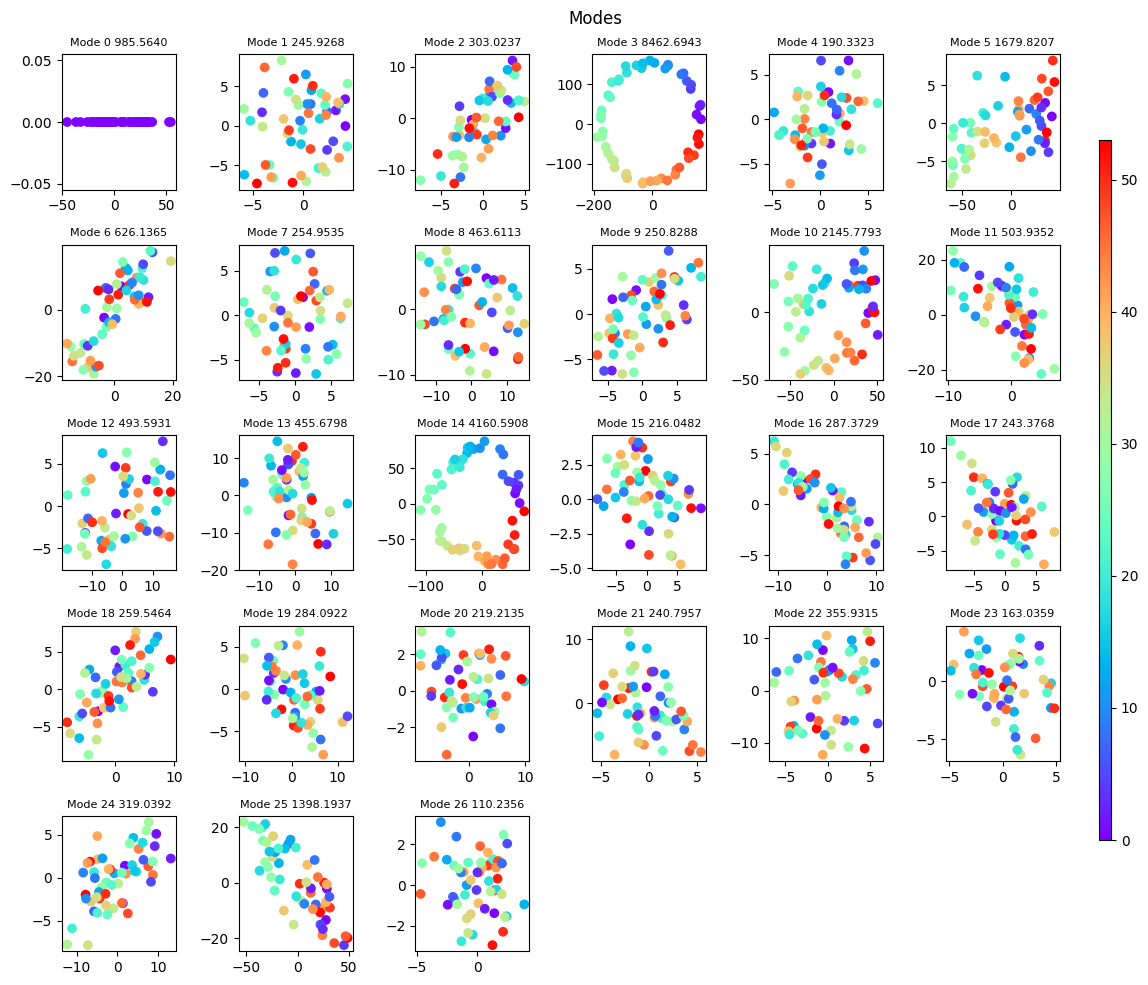

In [572]:
show_weights_modes(model.embedding.weight.detach().cpu())

In [573]:
get_loss_only_modes(model, [3, 14], test_data, device, hidden_dim=hidden_dim, tie_unembed=True)

1.1633514165878296

In [574]:
eval_model(model, test_data, device)

tensor(0.1247)

In [575]:
import matplotlib.cm as cm

<ipython-input-576-3570a3dd90a4>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("rainbow", num_plots)


<Figure size 640x480 with 0 Axes>

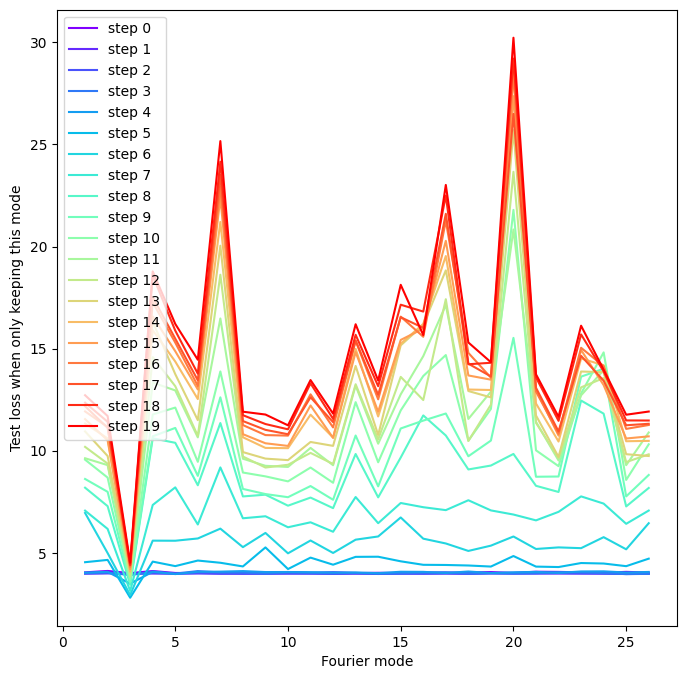

In [576]:
plt.clf()
plt.figure(figsize=(8, 8))
num_plots = len(mode_loss_history)
colormap = cm.get_cmap("rainbow", num_plots)

for idx, history in enumerate(mode_loss_history):
    color = colormap(idx)
    plt.plot(list(history.keys()), list(history.values()), color=color, label=f"step {idx}")
plt.xlabel("Fourier mode")
plt.ylabel("Test loss when only keeping this mode")
plt.legend()
plt.show()

<ipython-input-577-7bf6c3d6078e>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("rainbow", num_plots)


<Figure size 640x480 with 0 Axes>

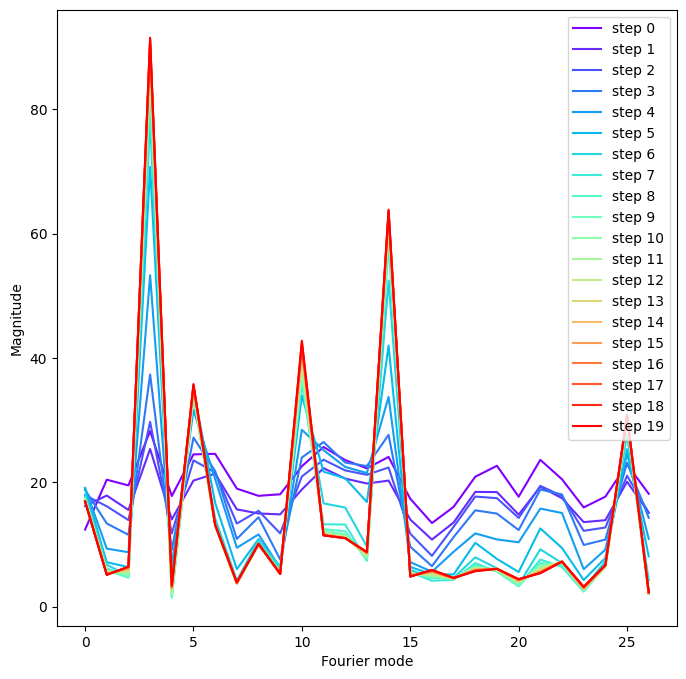

In [577]:
plt.clf()
plt.figure(figsize=(8, 8))
num_plots = len(magnitude_history)
colormap = cm.get_cmap("rainbow", num_plots)

for idx, history in enumerate(magnitude_history):
    color = colormap(idx)
    plt.plot(list(history)[:P//2 + 1], color=color, label=f"step {idx}")
plt.xlabel("Fourier mode")
plt.ylabel("Magnitude")
plt.legend()
plt.show()